In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
torch.manual_seed(1)
print(device)

In [32]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss, epochs):
    """
    Plots the training and validation loss against the number of epochs.

    Args:
        train_loss (list): List of training loss values.
        val_loss (list): List of validation loss values.
        epochs (int): Number of epochs trained for.

    Returns:
        None
    """
    plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [2]:
data = np.load("./data/ae_data.npz")

Str = data["Str"]
Xtr = torch.from_numpy(data["Xtr"]).type(torch.int)
Ytr = torch.from_numpy(data["Ytr"]).type(torch.float)

Ste = data["Ste"]
Xte = torch.from_numpy(data["Xte"]).type(torch.int)
Yte = torch.from_numpy(data["Yte"]).type(torch.float)

In [3]:
class ArithmeticExpressionDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]#.unsqueeze(0)
        y = self.Y[idx]
        return x, y


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2)

train_dataset = ArithmeticExpressionDataset(X_train, Y_train)
val_dataset = ArithmeticExpressionDataset(X_val, Y_val)

# Create data loaders for training and validation
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [40]:
import torch
import torch.nn as nn


class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, embedding_size):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.embedding_size = embedding_size

        # Define embedding layer
        self.embedding = nn.Embedding(input_size, embedding_size)

        # Define RNN layer
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True,nonlinearity="relu")

        # Define output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Convert input sequence to embeddings
        x = self.embedding(x)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the output of the RNN
        out = self.fc(out[:, -1, :])

        return out


In [41]:
import torch
from torch.utils.data import DataLoader

# Define hyperparameters
num_epochs = 1000
batch_size = 1024
learning_rate = 1e-4
hidden_size = 64
num_layers = 4
embedding_size=16
model = RNNModel(input_size=13, hidden_size=hidden_size, num_layers=num_layers, output_size=1,embedding_size=embedding_size)

# Define loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
val_loss_list=[]
train_loss_list=[]
for epoch in range(num_epochs):
    # set model to train mode
    model.train()
    
    train_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        # zero the gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # update train loss
        train_loss += loss.item()
    # set model to eval mode
    model.eval()
    
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # update validation loss
            val_loss += loss.item()

    # print train and validation loss
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/1000, Train Loss: 186820.2223, Val Loss: 147505.2504
Epoch 2/1000, Train Loss: 111508.0412, Val Loss: 87052.7852
Epoch 3/1000, Train Loss: 65264.1269, Val Loss: 46524.4616
Epoch 4/1000, Train Loss: 40220.4475, Val Loss: 42814.6858
Epoch 5/1000, Train Loss: 33969.9173, Val Loss: 29833.1582
Epoch 6/1000, Train Loss: 25923.1233, Val Loss: 22462.1215
Epoch 7/1000, Train Loss: 20039.3998, Val Loss: 16417.7373
Epoch 8/1000, Train Loss: 12311.9886, Val Loss: 7272.9492
Epoch 9/1000, Train Loss: 5591.5709, Val Loss: 4358.0093
Epoch 10/1000, Train Loss: 3681.0205, Val Loss: 2345.8117
Epoch 11/1000, Train Loss: 2239.4682, Val Loss: 1759.5796
Epoch 12/1000, Train Loss: 1586.3604, Val Loss: 1456.5470
Epoch 13/1000, Train Loss: 1586.1107, Val Loss: 2243.5917
Epoch 14/1000, Train Loss: 1281.8349, Val Loss: 1327.1510
Epoch 15/1000, Train Loss: 894.6866, Val Loss: 841.8432
Epoch 16/1000, Train Loss: 1130.1617, Val Loss: 1572.1980
Epoch 17/1000, Train Loss: 934.0013, Val Loss: 649.9927
Epoch 18/

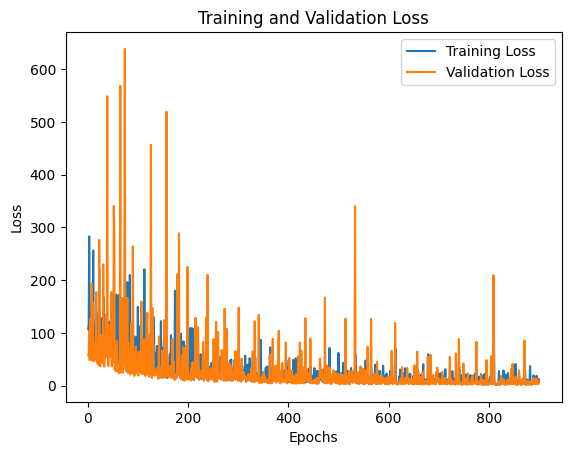

In [44]:
plot_loss(train_loss_list[100:],val_loss_list[100:],num_epochs-100)

In [60]:
torch.save(model.state_dict(),"./models/modelRNNES16HS64_final")

In [59]:
len(train_loader)

71

In [1]:
min(train_loss_list)

NameError: name 'train_loss_list' is not defined